# Bayesian introduction Jupyter notebook

In [15]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy

#Some pretty colors I like
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [16]:
# Define the true function
#Note that we are going to fit a straight line, not the same as what generated the data. You can play with increasing
#the data range and see how things deteriorate

def true_function_A(x):
    return 6*np.sin(x/3)


In [17]:
#Generating the data and using a fixed seed to reproduce results

np.random.seed(142857)
data_A_x=np.array([0.5,0.6,0.7,0.75,0.8,0.9,1.1,1.2,1.5,1.7,2.0])
data_A_errors=np.array([0.3,0.3,0.6,0.3,0.3,0.6,0.6,0.3,0.3,0.6,1])
data_A_y=np.random.multivariate_normal(true_function_A(data_A_x),np.diag(data_A_errors)**2)


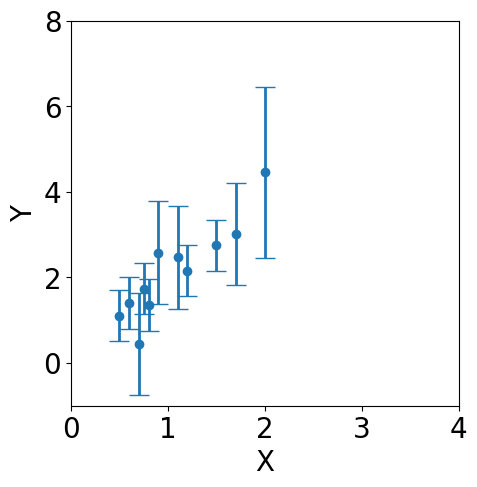

In [18]:
# Plot the data with error bars
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
ax.errorbar(data_A_x, data_A_y, yerr=2*data_A_errors, fmt='o', linewidth=2,capsize=7,label='Data [95% Errors]',color=colors[0])

x_func = np.linspace(0, 2.5, 100)

#If you want to see the true function that generated these, uncomment the following line
# ax.plot(x_func, true_function_A(x_func), label='True Function',color=colors[1])

# plt.legend(fontsize=15,frameon=True, edgecolor='black')

# Set the axis labels and title
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
# ax.set_title('Data with Error Bars')

plt.xlim(0,4)
plt.ylim(-1,8)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.show()


<font size="5">
The model we will use to fit to this data set is:
    
    

$f(x,\alpha) = \alpha_1+\alpha_2x$

In [19]:
def model_A(x,params):
    return params[0]+params[1]*x

In [20]:

# Define the likelihood function for given errors sigma
def likelihood(params,arguments):
#Assumed format for data=[xvals,yvals]
    data, model, sigmas = arguments
    likelihood_log_val=0

    for i in range(len(data[0])):
        likelihood_log_val=likelihood_log_val-1/2*((data[1][i] - model(data[0][i],params)) / sigmas[i])**2\
        -np.log(2*np.pi*sigmas[i]**2)/2
      
        
    return np.exp(likelihood_log_val)

# Define the prior function
def prior_model_A(params_vals,arguments):
    params0,params0_Cov_Inv_matrix=arguments
    mu=np.array(params_vals)-np.array(params0)
    params_size=len(params_vals)
    return (2*np.pi)**(-params_size/2)*np.linalg.det(params0_Cov_Inv_matrix)**(-1)*np.exp(-np.dot(mu,np.dot(params0_Cov_Inv_matrix,mu))/2)



In [21]:
# Define the Metropolis algorithm
def metropolis(data,sigma, prior,prior_arguments, likelihood,model,\
               num_iterations, step_size):
#     step_size should be a list the size of the parameters of the model
    likelihood_arguments=[data, model, sigma]
    initial_parameters=prior_arguments[0]
    #thermalizing
    burn_samples=1000
    # Set the initial state of the chain
    params_current=initial_parameters
    params_list=[]
    posterior_list=[]
    
    acceptance_times=0
    
    cov_step_size=np.diag(step_size)**2
    
    posterior_current=(likelihood(params_current,likelihood_arguments))*(prior(params_current,\
                                                                               prior_arguments))
    
    # Run the Metropolis-Hastings algorithm for burning
    for i in range(burn_samples):
        # Propose a new state for the chain
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*(prior(params_proposed,\
                                                                               prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed


    for i in range(num_iterations):
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*\
        (prior(params_proposed,prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed
            acceptance_times=acceptance_times+1

        # Store the current state
        params_list.append(params_current)
        posterior_list.append(posterior_current)
        
    
    #Rule of thumb acceptance is around 50%. 
    #You could plot the accuracy of the estimations as a function of this rate, that would be interesting to see. 
    print(acceptance_times/num_iterations*100,"%")
    
    return(np.array(params_list),np.array(posterior_list),\
           acceptance_times/num_iterations*100)



In [22]:
np.random.seed(142857)

#Setting up the prior
prior_arguments_A=[[0,1],np.linalg.inv(np.diag([2**2,2**2]))]

#Doing the Metropolis sampling for 100000 values
results_A=metropolis([data_A_x,data_A_y],data_A_errors, prior_model_A,\
                         prior_arguments_A, likelihood,model_A,100000, [0.2,0.2])
all_chains =results_A[0]

40.174 %


Lets plot the parameters we visited from the Metropolis algorithm using the corner package in python

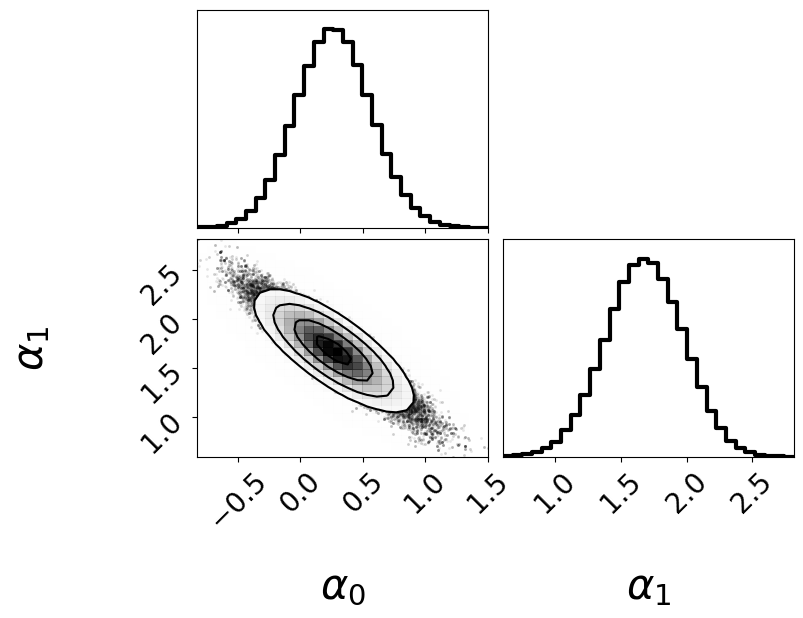

In [23]:

figure = corner.corner(all_chains,
    labels=[r'$\alpha_0$',r'$\alpha_1$'],
    labelpad=0.2,
                       bins=30,
    label_kwargs={"fontsize":30},
                      hist_kwargs= {"linewidth":3},
    quantiles=None
#                        ,truths=[0,1], truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 8
height = 6
figure.set_size_inches(width, height)
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)



In [24]:
#Taking 10000 samples from the visited posterior to estimate the percentiles in the model predictions

rng = np.random.default_rng()
alpha_rand = rng.choice(all_chains,(10000),replace=False)
func_rand=[model_A(x_func,alpha) for alpha in alpha_rand]


Lets make a plot of the predictions of our calibrated model

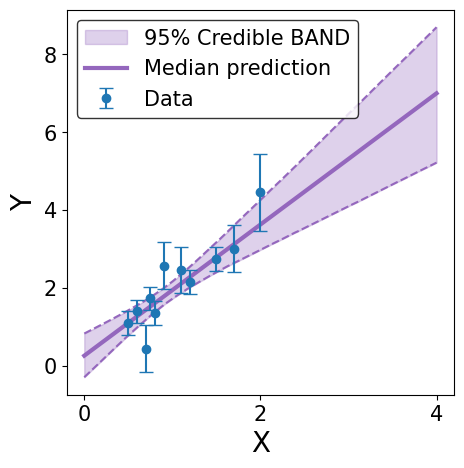

In [25]:
np.random.seed(142857)

x_func= np.linspace(0, 4, 200)
func_rand=[model_A(x_func,alpha) for alpha in alpha_rand]

fig, ax = plt.subplots(figsize=(5,5),dpi=100)
median = np.percentile(func_rand, 50, axis = 0)
upper = (np.percentile(func_rand, 97.5, axis = 0))

prediction_color_number=4

lower = (np.percentile(func_rand, 2.5, axis = 0))


ax.fill_between(x_func, lower, upper, color=colors[prediction_color_number], alpha=0.3,label='95% Credible BAND')

ax.plot(x_func, median, color=colors[prediction_color_number],linewidth=3,label='Median prediction')
ax.plot(x_func, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(x_func, upper, color=colors[prediction_color_number],linestyle='dashed')

#If you want to see the true function that generated these, uncomment the following line
# ax.plot(x_func, true_function_A(x_func), label='True Function',color='r', alpha=0.6)

ax.errorbar(data_A_x, data_A_y, yerr=data_A_errors, fmt='o', capsize=5,label='Data')


plt.legend(fontsize=15,frameon=True, edgecolor='black')


ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)

plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)

plt.show()

What if we want to predict the value of f at a specific location? For example x=3

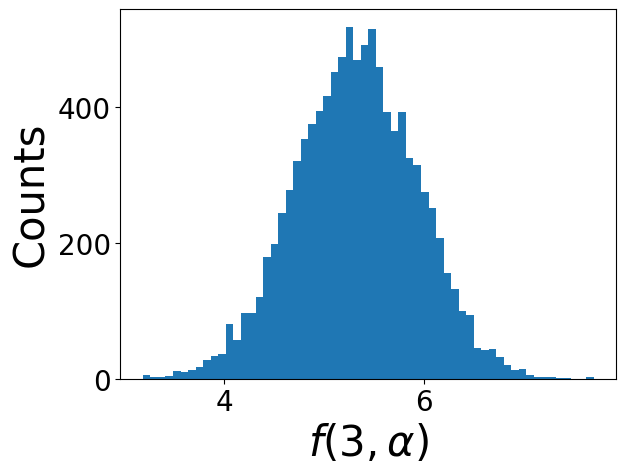

In [26]:
val3=[]

for i in range(len(alpha_rand)):
    val3.append(model_A(3,alpha_rand[i]))
val3=np.array(val3)


plt.hist(val3, bins=60)
plt.xlabel(r'$f(3,\alpha)$',fontsize=30)
plt.ylabel('Counts',fontsize=30)
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)
plt.show()

Finally, what if we are interested in the predictive distribution of new observations? We need to fold in the noise we expect to observe into our calculations. 

See Eq. 30 and Sec 4 in: https://www.frontiersin.org/articles/10.3389/fphy.2022.1054524/full

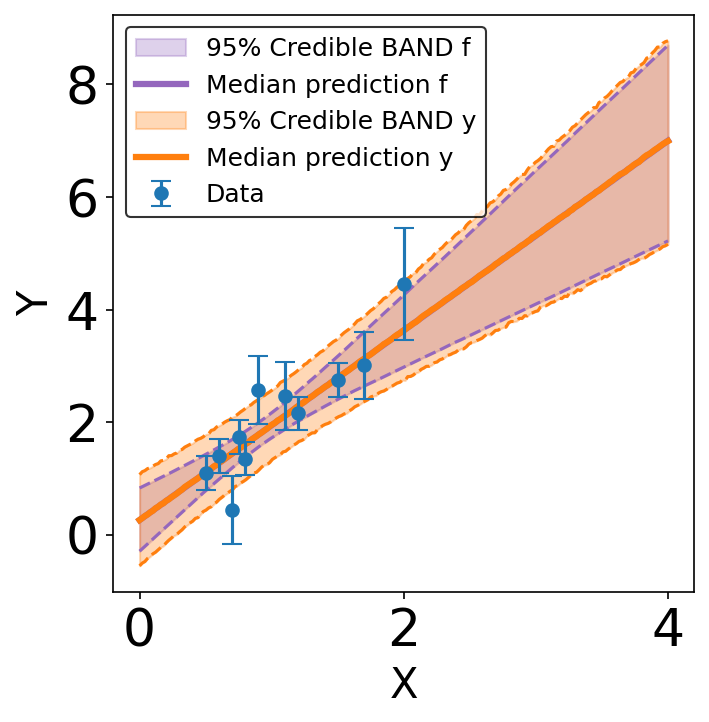

In [27]:
np.random.seed(142857)
fig, ax = plt.subplots(figsize=(5,5),dpi=150)

x_func= np.linspace(0, 4, 200)

func_rand=[model_A(x_func,alpha) for alpha in alpha_rand]

median = np.percentile(func_rand, 50, axis = 0)
upper = (np.percentile(func_rand, 97.5, axis = 0))
lower = (np.percentile(func_rand, 2.5, axis = 0))

sigma_value=0.3
y_rand=[model_A(x_func,alpha) for alpha in alpha_rand]\
+ np.random.normal(0, sigma_value, size=(len(alpha_rand), len(x_func)) )

mediany = np.percentile(y_rand, 50, axis = 0)
uppery = (np.percentile(y_rand, 97.5, axis = 0))
lowery = (np.percentile(y_rand, 2.5, axis = 0))




prediction_color_number=4


y_color_number=1


ax.fill_between(x_func, lower, upper, color=colors[prediction_color_number], alpha=0.3,label='95% Credible BAND f')

ax.plot(x_func, median, color=colors[prediction_color_number],linewidth=3,label='Median prediction f')
ax.plot(x_func, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(x_func, upper, color=colors[prediction_color_number],linestyle='dashed')

ax.fill_between(x_func, lowery, uppery, color=colors[y_color_number], alpha=0.3,label='95% Credible BAND y')

ax.plot(x_func, mediany, color=colors[y_color_number],linewidth=3,label='Median prediction y')
ax.plot(x_func, lowery, color=colors[y_color_number],linestyle='dashed')
ax.plot(x_func, uppery, color=colors[y_color_number],linestyle='dashed')


# ax.plot(x_func, true_function_A(x_func), label='True Function',color='r', alpha=0.6)

ax.errorbar(data_A_x, data_A_y, yerr=data_A_errors, fmt='o', capsize=5,label='Data')


plt.legend(fontsize=12,frameon=True, edgecolor='black')


ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
# ax.set_title('Data with Error Bars')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)



# plt.xlim(0,6)
# plt.ylim(-1,12)

plt.show()

Fantastic! Now you can tackle the other 7 problems :)